In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.stats import zscore

from collections import defaultdict, Counter

import scipy.spatial as sp
import scipy.cluster.hierarchy as hc

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Summary

This notebook describes how to roughly reproduce the analysis leading up to Figure 3.

In [11]:
hs_muts = pd.read_hdf("../data/hs_muts.h5",key="hs_muts")
damaging_muts = pd.read_hdf("../data/damaging_muts.h5",key="damaging_muts")

chromatin_profiling = pd.read_hdf("../data/CCLE_GlobalChromatinProfiling_20181130.hdf",key="chromatin_profiling")
mutation_calls = pd.read_hdf("../data/depmap_19Q1_mutation_calls.h5",key="mutation_calls")

In [22]:
chromatin_profiling = chromatin_profiling.dropna(axis=1,thresh=875)

In [57]:
muts_align, chromatin_align = hs_muts.align(chromatin_profiling,axis=0,join="inner")

In [79]:
crebbp = mutation_calls[mutation_calls["Hugo_Symbol"]=="CREBBP"]
crebbp[crebbp["Variant_annotation"]=="damaging"]

,Hugo_Symbol,Entrez_Gene_Id,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,...,VA_WES_AC,CGA_WES_AC,SangerWES_AC,SangerRecalibWES_AC,RNAseq_AC,HC_AC,RD_AC,WGS_AC,Variant_annotation,DepMap_ID
44657,CREBBP,1387,37,16,3777734,3777734,+,Frame_Shift_Del,DEL,A,...,NaN,NaN,42:11,53:99,NaN,NaN,NaN,NaN,damaging,ACH-000136
46376,CREBBP,1387,37,16,3830732,3830732,+,Splice_Site,SNP,C,...,NaN,NaN,NaN,NaN,7:2,NaN,NaN,NaN,damaging,ACH-000143
55016,CREBBP,1387,37,16,3786144,3786144,+,Nonsense_Mutation,SNP,C,...,NaN,NaN,59:33,59:33,69:77,162:85,NaN,NaN,damaging,ACH-000174
61889,CREBBP,1387,37,16,3790512,3790512,+,Nonsense_Mutation,SNP,G,...,NaN,NaN,11:30,9:29,NaN,53:84,NaN,NaN,damaging,ACH-000198
73171,CREBBP,1387,37,16,3781773,3781784,+,Splice_Site,DEL,CTACCTCCTTGT,...,NaN,NaN,14:0,18:40,58:119,244:173,NaN,NaN,damaging,ACH-000233
101834,CREBBP,1387,37,16,3801740,3801740,+,Frame_Shift_Del,DEL,A,...,NaN,NaN,21:5,26:37,42:75,NaN,NaN,NaN,damaging,ACH-000315
101835,CREBBP,1387,37,16,3801794,3801794,+,Nonsense_Mutation,SNP,C,...,NaN,NaN,NaN,23:19,51:48,NaN,NaN,NaN,damaging,ACH-000315
104437,CREBBP,1387,37,16,3795356,3795356,+,Splice_Site,SNP,C,...,NaN,NaN,NaN,NaN,NaN,14:77,NaN,17:73,damaging,ACH-000322
118313,CREBBP,1387,37,16,3786145,3786145,+,Frame_Shift_Del,DEL,A,...,NaN,NaN,23:6,30:68,48:82,139:163,NaN,29:39,damaging,ACH-000360
128799,CREBBP,1387,37,16,3900588,3900588,+,Nonsense_Mutation,SNP,G,...,44:46,44:46,NaN,NaN,126:81,14:15,NaN,NaN,damaging,ACH-000388


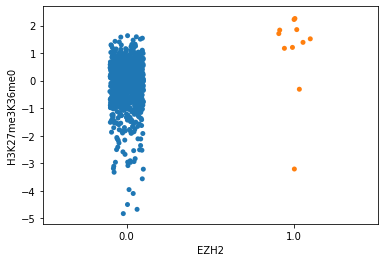

In [93]:
sns.stripplot(col_colors,chromatin_profiling["H3K27me3K36me0"])

In [91]:
col_colors = muts_align["EZH2"]

subtype_palette = sns.color_palette(
    "Blues", len(col_colors.unique()))
subtype_color_map = dict(
    zip(col_colors.unique(), subtype_palette))
subtype_colors = col_colors.map(subtype_color_map)

subtype_colors

ACH-000001    (0.6718954248366014, 0.8143790849673203, 0.900...
ACH-000002    (0.6718954248366014, 0.8143790849673203, 0.900...
ACH-000004    (0.6718954248366014, 0.8143790849673203, 0.900...
ACH-000005    (0.6718954248366014, 0.8143790849673203, 0.900...
ACH-000006    (0.6718954248366014, 0.8143790849673203, 0.900...
                                    ...                        
ACH-001190    (0.6718954248366014, 0.8143790849673203, 0.900...
ACH-001306    (0.6718954248366014, 0.8143790849673203, 0.900...
ACH-001307    (0.6718954248366014, 0.8143790849673203, 0.900...
ACH-001318    (0.6718954248366014, 0.8143790849673203, 0.900...
ACH-001321    (0.6718954248366014, 0.8143790849673203, 0.900...
Name: EZH2, Length: 897, dtype: object

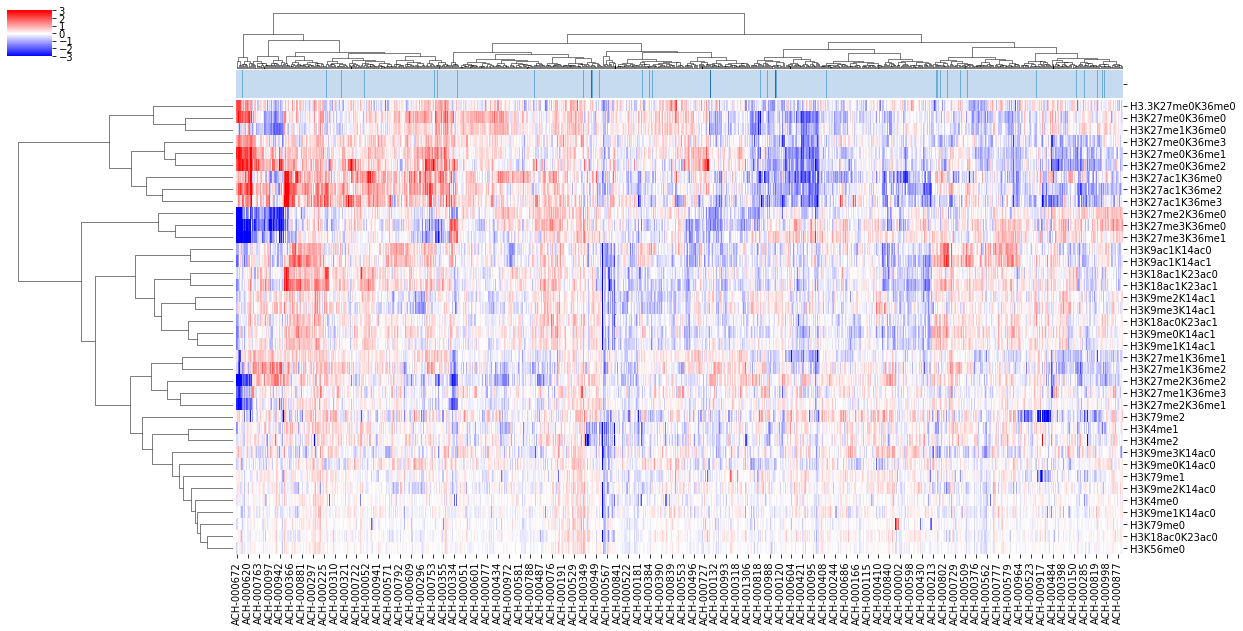

In [74]:
sns.clustermap(chromatin_align.fillna(chromatin_align.mean()).clip(-3,3).T,
               method="ward",
               cmap="bwr",
               col_colors=subtype_colors,
               figsize=(20,10)
              )